In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import csv

from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer 

#### Load Recipes Data

In [2]:
recipes = json.load(open('./data/recipe_train.json'))

#### Convert recipe to text document

In [3]:
recipes_as_doc = {}

for sample in recipes:
    key = sample['cuisine']
    # If key is in the dictionary, return its value. If not, insert key with a value of default and return default.
    recipes_as_doc.setdefault(key,[]).append(' '.join(sample['ingredients']).lower())

# create a single list with all the documents
all_docs = []
for k, v in recipes_as_doc.items():
   all_docs.append(' '.join(v))

#### Tfidf vectorizer for text data

In [4]:
# code adapted from https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf

vectorizer = TfidfVectorizer(use_idf=True)
transformed_documents = vectorizer.fit_transform(all_docs)

#### Analyze results

In [5]:
transformed_documents_as_array = transformed_documents.toarray()
len(transformed_documents_as_array)
docs_scores_dfs = {}

# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
for counter, doc in enumerate(transformed_documents_as_array):
    # construct a data frame
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame\
        .from_records(tf_idf_tuples, columns=['term', 'score'])\
        .sort_values(by='score', ascending=False)\
        .reset_index(drop=True)
    docs_scores_dfs[list(recipes_as_doc.keys())[counter]] = one_doc_as_df

    print(list(recipes_as_doc.keys())[counter], end=' ')
    # print(one_doc_as_df)
    # output to a csv using the enumerated value for the filename
    #one_doc_as_df.to_csv("tf.idf" + counter.__str__() + ".csv")

greek southern_us filipino indian jamaican spanish italian mexican chinese british thai vietnamese cajun_creole brazilian french japanese irish korean moroccan russian 

#### Statistics of Scores

Text(0, 0.5, 'Number of Therms')

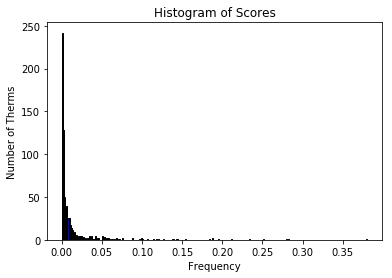

In [6]:
statistics = {}
for k in docs_scores_dfs.keys():
    df = docs_scores_dfs[k]
    scores = df['score']
    scores = scores.loc[scores>0.0]
    statistics[k] = [scores.mean(), scores.max(), scores.min(), df['score'].astype(bool).sum(axis=0)]

irish_scores = docs_scores_dfs["irish"]["score"]
irish_scores = irish_scores.loc[irish_scores>0.0]
plt.hist(irish_scores, color = 'blue', edgecolor = 'black', bins=300)
plt.title('Histogram of Scores')
plt.xlabel('Frequency')
plt.ylabel('Number of Therms')
# print(statistics)

#### Top 10 therms per cuisine

In [7]:
for k in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[k]
    print('-------------')
    print(k)
    print(scores_df.iloc[:10,:])


-------------
greek
     term     score
0   fresh  0.297130
1  pepper  0.294340
2     oil  0.287714
3    salt  0.260512
4   olive  0.260163
5    feta  0.231165
6  ground  0.226684
7   lemon  0.224591
8  garlic  0.220058
9  cheese  0.202621
-------------
southern_us
     term     score
0    salt  0.374617
1  pepper  0.329929
2   sugar  0.285364
3  butter  0.265297
4   flour  0.227380
5  ground  0.189832
6    eggs  0.170627
7  powder  0.160286
8     oil  0.157209
9     all  0.155608
-------------
filipino
     term     score
0   sauce  0.327662
1  garlic  0.325087
2  pepper  0.323156
3    salt  0.309637
4     oil  0.306418
5  onions  0.252988
6   water  0.224020
7   sugar  0.205352
8     soy  0.186683
9  ground  0.173165
-------------
indian
     term     score
0  ground  0.356060
1    salt  0.304793
2     oil  0.259010
3  garlic  0.208764
4   fresh  0.208637
5   cumin  0.199327
6  masala  0.198498
7  powder  0.191293
8  ginger  0.188105
9   garam  0.181433
-------------
jamaican
       

#### Load Baskets Market Data

In [8]:
baskets = []
with open('./data/groceries.csv', newline=None) as f:
  reader = csv.reader(f)
  for row in reader:
    baskets.append(row)


#### Compute ngram for tf.idf top score 

In [9]:
top_scores_ngram = {}

for cuisine in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[cuisine]
    scores_df = scores_df[scores_df['score']>(statistics[cuisine][1]/4)]
    #scores_df = scores_df.iloc[:30,:]
    scores_df = scores_df.sort_values(by=['score'],ascending=False)
    
    ngram_scores = []
    for index, row in scores_df.iterrows():
        ngram = list(ngrams(row['term'], 3))
        score =  row['score']
        ngram_scores.append([ngram, score])
        
    top_scores_ngram[cuisine] = ngram_scores

#### Define the metric similarity

In [10]:
def jaccard_distance(a, b):
    """Calculate the jaccard distance between sets A and B"""
    a = set(a)
    b = set(b)
    return 1.0 * len(a&b)/len(a|b)

#### Compute Basket Scores
For each basket we iterate over all items and compute their similarities with the top 
terms in the cuisines docs

In [15]:
random_sample = baskets[1:5]

for basket in random_sample:
    similarities = {}
    for cuisine in top_scores_ngram:
        value = 0
        for item in basket:      
            item_ngram = list(ngrams(item, 3))
            for ngram_term, score in top_scores_ngram[cuisine]:
                sim = jaccard_distance(item_ngram, ngram_term)
                if sim > 0:
                    value += sim * score
                    
        similarities[cuisine] = value
    
           
    print('------------------')
    print("basket: ", basket)
    for k in similarities:
        print(k, similarities[k]) 

------------------
basket:  ['tropical fruit', 'yogurt', 'coffee']
greek 0.10241275529637707
southern_us 0
filipino 0
indian 0.007831750135041945
jamaican 0.00896178143626634
spanish 0
italian 0
mexican 0.011192918757604016
chinese 0
british 0
thai 0.009599370651770743
vietnamese 0.009014482315274278
cajun_creole 0
brazilian 0.005963294490704046
french 0
japanese 0
irish 0
korean 0
moroccan 0
russian 0
------------------
basket:  ['whole milk']
greek 0
southern_us 0.04960716216893462
filipino 0.03073840194700457
indian 0
jamaican 0
spanish 0
italian 0
mexican 0
chinese 0
british 0.048849914400755895
thai 0.03532042406939207
vietnamese 0
cajun_creole 0
brazilian 0.0659520041258831
french 0.024803461743219055
japanese 0
irish 0.05224165803800015
korean 0
moroccan 0
russian 0.027135285015782166
------------------
basket:  ['pip fruit', 'yogurt', 'cream cheese', 'meat spreads']
greek 0.1834609857241567
southern_us 0.09044927647979664
filipino 0
indian 0
jamaican 0
spanish 0
italian 0.13611